# Saudi Aramco Strategy Analysis: To Invest or To Trade?

In this notebook, I will explore how a **long-term buy-and-hold strategy** compares to a **short-term Simple Moving Average (SMA) crossover strategy** for **Saudi Aramco’s stock**.

Using historical stock data from the past five years, I will:

- **Calculate the dividend-adjusted annualized return** for an investor who bought and held the stock
- **Backtest and apply walk-forward cross-validation** to determine the best short-term and long-term SMA parameters
- **Compare the two strategies** and analyze **why one outperforms the other** for this specific ticker

The goal is to help **investors and analysts** make more **informed decisions** and have **full confidence in their strategy**, regardless of the market's state.

## Importing Essential Modules & Initializing Aramco's Stock DataFrame

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [8]:
aramco_stock = yf.download("2222.SR", "2019-12-01", "2025-07-13", multi_level_index=False, auto_adjust=False)
aramco_stock.reset_index(inplace=True)
aramco_stock

[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2019-12-11,24.458281,29.090908,29.090908,29.090908,29.090908,38289394
1,2019-12-12,25.570021,30.413223,31.983471,29.752066,31.983471,505692621
2,2019-12-15,25.986927,30.909090,30.991735,30.413223,30.661158,98349281
3,2019-12-16,26.403830,31.404959,31.487602,30.991735,30.991735,105973907
4,2019-12-17,26.230120,31.198347,31.528925,30.991735,31.446280,142672245
...,...,...,...,...,...,...,...
1386,2025-07-06,24.870001,24.870001,24.889999,24.549999,24.780001,9678871
1387,2025-07-07,25.080000,25.080000,25.139999,24.780001,24.870001,11038097
1388,2025-07-08,25.100000,25.100000,25.120001,24.980000,25.059999,11042534
1389,2025-07-09,24.879999,24.879999,25.120001,24.820000,25.080000,7350422


## Buy-And-Hold Performance

**Firstly**, let's calculate the **average annualized return** for an investor who **bought Saudi Aramco stock five years ago and held it without making any trades**. For simplicity, let's assume the **dividend yield remained constant at its 5.39% average** and calculate the returns over the period from **July 1, 2020 to July 1, 2025**. Let's also assume that the **yields from capital gains and dividends are compounded annually**.

In [ ]:
STARTING_CASH = 100
DIVIDEND_MULTIPLIER = 1.0539
START_DATE = "2020-07-01"
END_DATE = "2025-07-01"

# calculate annualized growth with dividends
shares_owned = STARTING_CASH / aramco_stock["Open"][aramco_stock["Date"] == START_DATE].iloc[0]
final_shares_price = shares_owned * aramco_stock["Open"][aramco_stock["Date"] == END_DATE].iloc[0]
compound_annual_growth_multiplier = (final_shares_price / STARTING_CASH) ** (1/5)
compound_annual_growth_multiplier_with_dividends = compound_annual_growth_multiplier * DIVIDEND_MULTIPLIER

print(f"On {START_DATE}, {STARTING_CASH} SAR buys {shares_owned:.2f} shares of Saudi Aramco stock.")
print(f"On {END_DATE}, these shares are worth {final_shares_price:.2f} SAR, showing a compound annual growth rate of {(compound_annual_growth_multiplier - 1) * 100:.2f}%.")
print(f"With dividends reinvested at a yield of {(DIVIDEND_MULTIPLIER - 1) * 100:.2f}%, the finalized annual return is {(compound_annual_growth_multiplier_with_dividends - 1) * 100:.2f}%.")

On 2020-07-01, 100 SAR buys 3.73 shares of Saudi Aramco stock.
On 2025-07-01, these shares are worth 90.68 SAR, showing a compound annual growth rate of -1.94%.
With dividends reinvested at a yield of 5.39%, the finalized annual return is 3.35%.


As can be observed, the **annualized return rate** for someone who **bought and held without trading** is **3.35%**, a **moderate return** for a passive strategy. Let's now dig deeper into the **SMA crossover strategy** to see if this return can be **outperformed by a more active trading approach**.

## Simple Moving Average (SMA) Crossover Performance

The way this strategy works is by calculating a **short-term** and **long-term SMA** of the stock price each day based on the **opening price**. A **buy position** is taken when the short-term SMA crosses **above** the long-term SMA, and a **sell position** is taken when it crosses **below**. For simplicity, let's assume **no brokerage fees** or **bid/ask spread**, and the strategy will always **buy or sell using 100% of the available capital**. Let's also assume **fractional shares are allowed**.

Before we **optimize the returns** of this strategy by tuning the **short-term** and **long-term SMA parameters** using **grid search** and **walk-forward cross-validation**, let's first analyze a few statistics to ensure my results **make numerical sense**.

Firstly, let's calculate the **expected value of the annual yield** if an investor were to select the **short-term** and **long-term SMA parameters at random** from a **uniform distribution of possible combinations**. We will also **determine the best parameters** for the short-term and long-term SMA durations.

In [27]:
short_term_values = range(10, 51, 5)
long_term_values = range(60, 141, 10)

annual_yields = []
maximum_yield = -float("inf")
maximum_params = (None, None)

for short_term_param in short_term_values:
    for long_term_param in long_term_values:
        current_cash = STARTING_CASH
        current_shares = 0

        # initial dataframe adjusted for the start and end dates for easier indexing
        aramco_stock_date_adjusted = aramco_stock[
            (aramco_stock["Date"] >= START_DATE) & (aramco_stock["Date"] <= END_DATE)
        ]

        # short-term and long-term series of the simple moving averages
        short_term_sma = aramco_stock["Open"].rolling(short_term_param).mean()[
            (aramco_stock["Date"] >= START_DATE) & (aramco_stock["Date"] <= END_DATE)
        ]
        long_term_sma = aramco_stock["Open"].rolling(long_term_param).mean()[
            (aramco_stock["Date"] >= START_DATE) & (aramco_stock["Date"] <= END_DATE)
        ]

        # determine if the initial position should be buy or sell
        if short_term_sma.iloc[0] > long_term_sma.iloc[0]:
            current_shares = current_cash / aramco_stock_date_adjusted["Open"].iloc[0]
            current_cash = 0

        # check for a crossover and buy or sell accordingly
        for i in range(1, len(short_term_sma)):
            if short_term_sma.iloc[i] > long_term_sma.iloc[i] and short_term_sma.iloc[i - 1] < long_term_sma.iloc[i - 1]:
                current_shares = current_cash / aramco_stock_date_adjusted["Open"].iloc[i]
                current_cash = 0
            elif short_term_sma.iloc[i] < long_term_sma.iloc[i] and short_term_sma.iloc[i - 1] > long_term_sma.iloc[i - 1]:
                current_cash = current_shares * aramco_stock_date_adjusted["Open"].iloc[i]
                current_shares = 0

        final_yield = max(current_cash, current_shares * aramco_stock_date_adjusted["Open"].iloc[-1]) / 100
        
        if final_yield > maximum_yield:
            maximum_yield = final_yield
            maximum_params = (short_term_param, long_term_param)
        
        annual_yields.append(final_yield)

cumulative_yield = np.mean(annual_yields)
annualized_yield = cumulative_yield ** (1/5)

print(f"Expected Cumulative Yield: {(cumulative_yield - 1) * 100:.2f}%")
print(f"Expected Annualized Yield: {(annualized_yield - 1) * 100:.2f}%")
print(f"Maximum Cumulative Yield: {(maximum_yield - 1) * 100:.2f}%")
print(f"Maximum Annualized Yield: {(maximum_yield ** (1/5) - 1) * 100:.2f}%")
print(f"Best Performing Short-Term Parameter: {maximum_params[0]} Days")
print(f"Best Performing Long-Term Parameter: {maximum_params[1]} Days")

Expected Cumulative Yield: 13.14%
Expected Annualized Yield: 2.50%
Maximum Cumulative Yield: 36.56%
Maximum Annualized Yield: 6.43%
Best Performing Short-Term Parameter: 30 Days
Best Performing Long-Term Parameter: 80 Days


As can be observed, the **expected annual yield** for a trader using the **SMA-crossover strategy** (excluding dividends) over the last five years is **2.50%**. The **best performance** occurs with **30-day** and **80-day** windows for the short-term and long-term SMAs, respectively, at **an annual yield of 6.43%**.

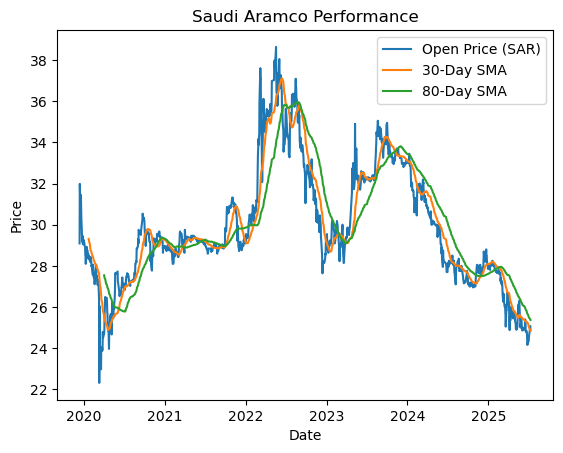

In [48]:
fig, ax = plt.subplots()

ax.plot(aramco_stock["Date"], aramco_stock["Open"], label="Open Price (SAR)")
ax.plot(aramco_stock["Date"], aramco_stock["Open"].rolling(30).mean(), label="30-Day SMA")
ax.plot(aramco_stock["Date"], aramco_stock["Open"].rolling(80).mean(), label="80-Day SMA")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Saudi Aramco Performance")
ax.legend();

### Introducing Walk-Forward Cross-Validation

Here’s an important point to consider: **If a trader uses the SMA crossover strategy with parameters (30, 80), can they realistically expect an annualized yield of around 6.43 %?** The simple answer is **no**.  

The reason for this is that we effectively treated the **entire dataset as a single training set** and performed a **grid search on that same data**. This approach **significantly increases the risk of overfitting**, meaning the parameters may simply fit historical noise rather than represent a reliable future edge.

To address this issue, we can use a machine learning technique called **walk‑forward cross‑validation (WFCV)**.  

**Key Ideas of WFCV:**  
  - We will divide the dataset into **multiple training and testing folds** while keeping the **chronological order intact**.  
  - Randomly shuffling would destroy the temporal structure and prevent us from measuring how time affects performance.  
  - For each fold, we will train on the past segment, then **validate on the following unseen segment**.  


For even more realism, **we will select the best‑performing SMA pair in each training fold** and then apply it on the subsequent test fold, allowing the strategy to **adapt parameters over time** as market conditions change. This process tests whether an SMA pair works **consistently across different market regimes** rather than just in one historical window. Notice how we **test on just five different SMA parameter pairs** to prevent the validation process from **being sensitive to noise** as it would be if we were fitting the training data to hundreds of combinations of SMA parameters.


In [134]:
folds = [
    {"train_start": "2020-07-01", "train_end": "2021-07-01", "test_end": "2022-01-01"},
    {"train_start": "2021-01-01", "train_end": "2022-01-01", "test_end": "2022-07-01"},
    {"train_start": "2021-07-01", "train_end": "2022-07-01", "test_end": "2023-01-01"},
    {"train_start": "2022-01-01", "train_end": "2023-01-01", "test_end": "2023-07-01"},
    {"train_start": "2022-07-01", "train_end": "2023-07-01", "test_end": "2024-01-01"},
    {"train_start": "2023-01-01", "train_end": "2024-01-01", "test_end": "2024-07-01"},
    {"train_start": "2023-07-01", "train_end": "2024-07-01", "test_end": "2025-01-01"},
    {"train_start": "2024-01-01", "train_end": "2025-01-01", "test_end": "2025-07-01"},
]

final_yields = []

for fold_index, fold in enumerate(folds):
    
    train = aramco_stock[
        (aramco_stock["Date"] >= fold["train_start"]) &
        (aramco_stock["Date"] < fold["train_end"])
    ]
    
    test = aramco_stock[
        (aramco_stock["Date"] >= fold["train_end"]) &
        (aramco_stock["Date"] < fold["test_end"])
    ]

    sma_pair_yields = {}

    for short_term, long_term in ((10, 50), (20, 100), (50, 200), (21, 55), (9, 21)):

        short_term_sma = aramco_stock["Open"].rolling(short_term).mean()[
            (aramco_stock["Date"] >= fold["train_start"]) &
            (aramco_stock["Date"] < fold["train_end"])
        ]
        
        long_term_sma = aramco_stock["Open"].rolling(long_term).mean()[
            (aramco_stock["Date"] >= fold["train_start"]) &
            (aramco_stock["Date"] < fold["train_end"])
        ]

        current_cash = STARTING_CASH
        current_shares = 0

        if short_term_sma.iloc[0] > long_term_sma.iloc[0]:
            current_shares = current_cash / train.iloc[0]["Open"]
            current_cash = 0

        for i in range(1, len(train)):
            if short_term_sma.iloc[i] > long_term_sma.iloc[i] and short_term_sma.iloc[i - 1] < long_term_sma.iloc[i - 1]:
                current_shares = current_cash / train.iloc[i]["Open"]
                current_cash = 0
            if short_term_sma.iloc[i] < long_term_sma.iloc[i] and short_term_sma.iloc[i - 1] > long_term_sma.iloc[i - 1]:
                current_cash = current_shares * train.iloc[i]["Open"]
                current_shares = 0

        sma_pair_yields[current_cash + current_shares * train.iloc[-1]["Open"]] = (short_term, long_term)

    short_term, long_term = sma_pair_yields[np.max(list(sma_pair_yields.keys()))]
    
    print(f"The best performing SMA parameter pair during Fold #{fold_index} was ({short_term}, {long_term}) at a cumulative (and annualized) yield of {np.max(list(sma_pair_yields.keys())) - 100:.2f}%.")

    short_term_sma = aramco_stock["Open"].rolling(short_term).mean()[
        (aramco_stock["Date"] >= fold["train_end"]) &
        (aramco_stock["Date"] < fold["test_end"])
    ]
    
    long_term_sma = aramco_stock["Open"].rolling(long_term).mean()[
        (aramco_stock["Date"] >= fold["train_end"]) &
        (aramco_stock["Date"] < fold["test_end"])
    ]

    current_cash = 100
    current_shares = 0

    if short_term_sma.iloc[0] > long_term_sma.iloc[0]:
        current_shares = current_cash / test.iloc[0]["Open"]
        current_cash = 0

    for i in range(1, len(test)):
        if short_term_sma.iloc[i] > long_term_sma.iloc[i] and short_term_sma.iloc[i - 1] < long_term_sma.iloc[i - 1]:
            current_shares = current_cash / test.iloc[i]["Open"]
            current_cash = 0
        if short_term_sma.iloc[i] < long_term_sma.iloc[i] and short_term_sma.iloc[i - 1] > long_term_sma.iloc[i - 1]:
            current_cash = current_shares * test.iloc[i]["Open"]
            current_shares = 0

    final_yield = max(current_cash, current_shares * test.iloc[-1]["Open"]) / 100
    print((current_cash + current_shares * test.iloc[-1]["Open"]) / 100)
    
    print(f"On the test set, this pair yielded a cumulative yield of {(final_yield - 1) * 100:.2f}% over a 6-month period.\n")

    final_yields.append(final_yield)

The best performing SMA parameter pair during Fold #0 was (9, 21) at a cumulative (and annualized) yield of 8.70%.
1.0476156201207736
On the test set, this pair yielded a cumulative yield of 4.76% over a 6-month period.

The best performing SMA parameter pair during Fold #1 was (9, 21) at a cumulative (and annualized) yield of 3.29%.
1.2869509215330088
On the test set, this pair yielded a cumulative yield of 28.70% over a 6-month period.

The best performing SMA parameter pair during Fold #2 was (9, 21) at a cumulative (and annualized) yield of 36.93%.
0.9731467789302641
On the test set, this pair yielded a cumulative yield of -2.69% over a 6-month period.

The best performing SMA parameter pair during Fold #3 was (9, 21) at a cumulative (and annualized) yield of 25.24%.
1.0350224876360299
On the test set, this pair yielded a cumulative yield of 3.50% over a 6-month period.

The best performing SMA parameter pair during Fold #4 was (9, 21) at a cumulative (and annualized) yield of 0.72

In [128]:
print(f"Final Cumulative Yield: {(np.prod(final_yields) - 1) * 100:.2f}%.")
print(f"Final Annualized Yield: {(np.prod(final_yields) ** (1/4) - 1) * 100:.2f}%.")

Final Cumulative Yield: 35.90%.
Final Annualized Yield: 7.97%.


### Final In-Depth Analysis

Not only have we managed to **extract a greater annual compounding rate** by tuning the hyperparameters according to last year's performance, but we are now more **confident in the accuracy of our prediction** as we have tested it thoroughly on several different folds.

There is one final point to address. Notice how we've **accumulated most of our expected gains during the second fold (28.69%)**, while most of the other folds yielded an accumulation of a **slightly positive yield at best**. 

This is **worrying** because 1.2869 is a few standard deviations away from the **mean yield**, and since it only occurred in **1 out of 8 folds**, we cannot safely expect similar gains.

To what do we attribute these gains and how can we ensure that **giving up a large portion of dividends** and relying on the **SMA crossover strategy** is the best decision for this market?

## The Final Takeaway – Trend Persistence

**Trend persistence** refers to how long a stock’s price continues to rise after an upward movement or continues to decline after a downward movement. Longer durations indicate greater trend persistence, and vice versa.  

It is one of the most important indicators of how well a stock will perform when applying the **SMA crossover strategy**. After a stock’s price begins to rise, it typically takes a few days (or even a few weeks) for the short-term SMA to overtake the long-term SMA.  

If, by the time the crossover occurs, the stock’s price has already started to fall (i.e., **low trend persistence**), this will generate a **false signal** for the SMA algorithm. In such a case, the trader ends up buying the stock just as it begins to decline, mistakenly assuming the trend is still upward.  

In the case of **Aramco**, the second fold represents a period where the stock exhibited **strong positive trend persistence**, which explains the large gains accumulated during that time. As shown in the graph from the previous subsection, this corresponds to early 2022, when **oil prices were at their highest levels in the past decade**.  

All in all, it is crucial to analyze **historical data** and observe how the stock has behaved in different market conditions. The key insight is that the **SMA crossover strategy performs best in trending markets** (markets with **high trend persistence**), where stock prices rise for a moderate-to-long duration and fall for a similar duration.